In [ ]:
#sempre lembrar de limpar a pasta tmp ao final do exercício

# import shutil
# shutil.rmtree('/tmp_img')
# shutil.rmtree('/tmp_csv')
# shutil.rmtree('/tmp_img_resized')

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import numpy as np
import cv2
import glob
import os
import re
from google.colab import drive
from functools import lru_cache
import requests
import seaborn as sns

In [32]:
AUTOENCODER_WIDTH = 160
AUTOENCODER_HEIGHT = 192
RESCALE_RATIO = 35
states = ['AC', 'AL', 'AP', 'AM', 'BA', 'CE', 'ES', 'GO', 'MA', 'MT', 'MS', 'MG', 'PA', 'PB', 'PR', 'PE', 'PI', 'RJ', 'RN', 'RS', 'RO', 'RR', 'SC', 'SP', 'SE', 'TO', 'DF']

In [33]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [34]:
def open_image_internet(url):
  return cv2.imdecode(np.asarray(bytearray(requests.get(url).content)), -1)

def open_image_local(path):
  img = cv2.imread(path, cv2.COLOR_BGR2RGB)
  return img

def BGR2RGB(img):
  return img[:,:,::-1]
  
def unzip_files(input_folder, file, output_folder):
  from_path = f'{input_folder}/{file}'
  zip_ref = zipfile.ZipFile(from_path, 'r')
  zip_ref.extractall(output_folder)
  zip_ref.close()

@lru_cache(maxsize=None)
def get_img_filenames(state):
  os.chdir('/tmp_img')
  img_lists = [glob.glob(e) for e in ('*'+state+'*.jpg', '*'+state+'*.png', '*'+state+'*.jpeg')]
  img_list = [item for sublist in img_lists for item in sublist]
  return set(img_list)

def get_img_filename_from_sq_candidato(state, sq_candidato):
  filenames = get_img_filenames(state)
  option1, option2 = 'F'+state+str(sq_candidato)+'_div.jpg', 'F'+state+str(sq_candidato)+'_div.jpeg'
  if option1 in filenames:
    return option1
  elif option2 in filenames:
    return option2
  else:
    return ''

def get_candidates_from_state(state):
  os.chdir('/tmp_csv')
  data_filename = glob.glob('*'+state+'.csv')
  data_df = pd.read_csv(r'/tmp_csv/'+data_filename[0], encoding='iso-8859-1', on_bad_lines='warn', sep=';')
  data_df['filename'] = data_df['SQ_CANDIDATO'].map(lambda sq_candidato: get_img_filename_from_sq_candidato(state, sq_candidato))
  return data_df[['NM_CANDIDATO', 'DS_CARGO', 'SQ_CANDIDATO', 'DS_SIT_TOT_TURNO', 'CD_SIT_TOT_TURNO', 'filename']].query('filename != ""') 

def get_candidates():
  return pd.concat([get_candidates_from_state(state) for state in states])

def get_elected(candidate_df):
  return candidate_df.query('DS_SIT_TOT_TURNO == "ELEITO" or DS_SIT_TOT_TURNO == "ELEITO POR MÉDIA"') 

def get_not_elected(candidate_df):
  return candidate_df.query('DS_SIT_TOT_TURNO == "NÃO ELEITO"')

def get_faces(elected_df):
  return np.array([open_image_local('/tmp_img/'+filename) for filename in elected_df['filename'].values])

def get_cropped_face(face):
  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt.xml')
  gray = cv2.cvtColor(face, cv2.COLOR_RGB2GRAY)
  faces = face_cascade.detectMultiScale(gray, 1.3, 5)
  if len(faces):
    (x,y,w,h) = faces[0]
    img_cropped = face[
        max(0,y-30):
        min(face.shape[0]-1,y+h+30), 
        max(0, x-30):
        min(face.shape[1]-1,x+w+30),
        :]
    return img_cropped
  else:
    square = min(face.shape[0], face.shape[1])//2
    mid_height = face.shape[0]//2
    mid_width = face.shape[1]//2
    return face[mid_height-square:mid_height+square,mid_width-square:mid_width+square]

def get_cropped_faces(faces):
  return np.array([get_cropped_face(face) for face in faces])

def get_padded_face(face, x_max=AUTOENCODER_WIDTH, y_max=AUTOENCODER_HEIGHT):
  scale = min(y_max/face.shape[0], x_max/face.shape[1])
  resized_face = cv2.resize(face, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)

  delta_w = x_max - resized_face.shape[1]
  delta_h = y_max - resized_face.shape[0]
  top, bottom = delta_h//2, delta_h-(delta_h//2)
  left, right = delta_w//2, delta_w-(delta_w//2)

  return cv2.copyMakeBorder(resized_face, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[255, 255, 255])

def get_resized_faces(faces):
  return np.array([get_padded_face(face) for face in faces])

def get_flatten_faces(faces):
  return faces.reshape((faces.shape[0], np.prod(faces.shape[1:])))

def output_imgs(folder, candidates_df, resized_imgs):
  if not os.path.exists(folder):
    os.makedirs(folder)
  os.chdir(folder)

  for idx_row in range(candidates_df.shape[0]):
    filename = candidates_df.iloc[idx_row]['filename']
    if filename != '':
      cv2.imwrite(filename, resized_imgs[idx_row])
    else:
      continue

Unzip Files

In [35]:
unzip_files('/content/gdrive/MyDrive/Bootcamp_ENAP_2022/2022', 'consulta_cand_2022.zip', '/tmp_csv')
for state in states:
  unzip_files('/content/gdrive/MyDrive/Bootcamp_ENAP_2022/2022', 'foto_cand2022_'+state+'_div.zip', '/tmp_img')

Save Resized Images (Only Play Me Once)

In [ ]:
candidates_df = get_candidates()
candidates_faces = get_faces(candidates_df)
candidates_faces = get_cropped_faces(candidates_faces)
candidates_faces = get_resized_faces(candidates_faces)
output_imgs('/tmp_img_resized',  candidates_df, candidates_faces)

In [ ]:
from google.colab import files
!zip -r /content/img_resized.zip /tmp_img_resized
files.download("/content/img_resized.zip")


Play for Real

In [36]:
def see_cropped_faces(photos, cropped_photos, resized_cropped_photos, n_photos):
  n_cols = 3
  lines = np.random.choice(photos.shape[0], n_photos, replace=False)
  fig, axs = plt.subplots(n_photos, n_cols, figsize=(15,30))
  for idx, (img_orig, img_cropp, img_resized) in enumerate(zip(photos[lines], cropped_photos[lines], resized_cropped_photos[lines])):
    axs[idx][0].imshow(BGR2RGB(img_orig));
    axs[idx][1].imshow(BGR2RGB(img_cropp));
    axs[idx][2].imshow(BGR2RGB(img_resized));

In [37]:
def pca_plot_faces_and_their_reconstructions(pca, photos, n_photos):
  lines = np.random.choice(photos.shape[0], n_photos, replace=False)

  elected_person_images = photos[lines]

  flattened_faces = get_flatten_faces(elected_person_images)
  data_projected = pca.transform(flattened_faces)
  reconstructed_photos = pca.inverse_transform(data_projected).reshape((n_photos, photos.shape[1], photos.shape[2], photos.shape[3]))

  fig, axs = plt.subplots(n_photos, 2, figsize=(15,30))
  for idx, (img_orig, img_reconstructed) in enumerate(zip(elected_person_images, reconstructed_photos)):
    axs[idx][0].imshow(BGR2RGB(img_orig));
    axs[idx][1].imshow(BGR2RGB(img_reconstructed));

Carregar Imagens

In [38]:
elected_df = get_elected(get_candidates())
elected_faces = get_faces(elected_df)
cropped_elected_faces = get_cropped_faces(elected_faces)
resized_cropped_ellected_faces = get_resized_faces(cropped_elected_faces)
elected_flattened_faces = get_flatten_faces(resized_cropped_ellected_faces)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Faces: variável com os rostos dos candidatos eleitos

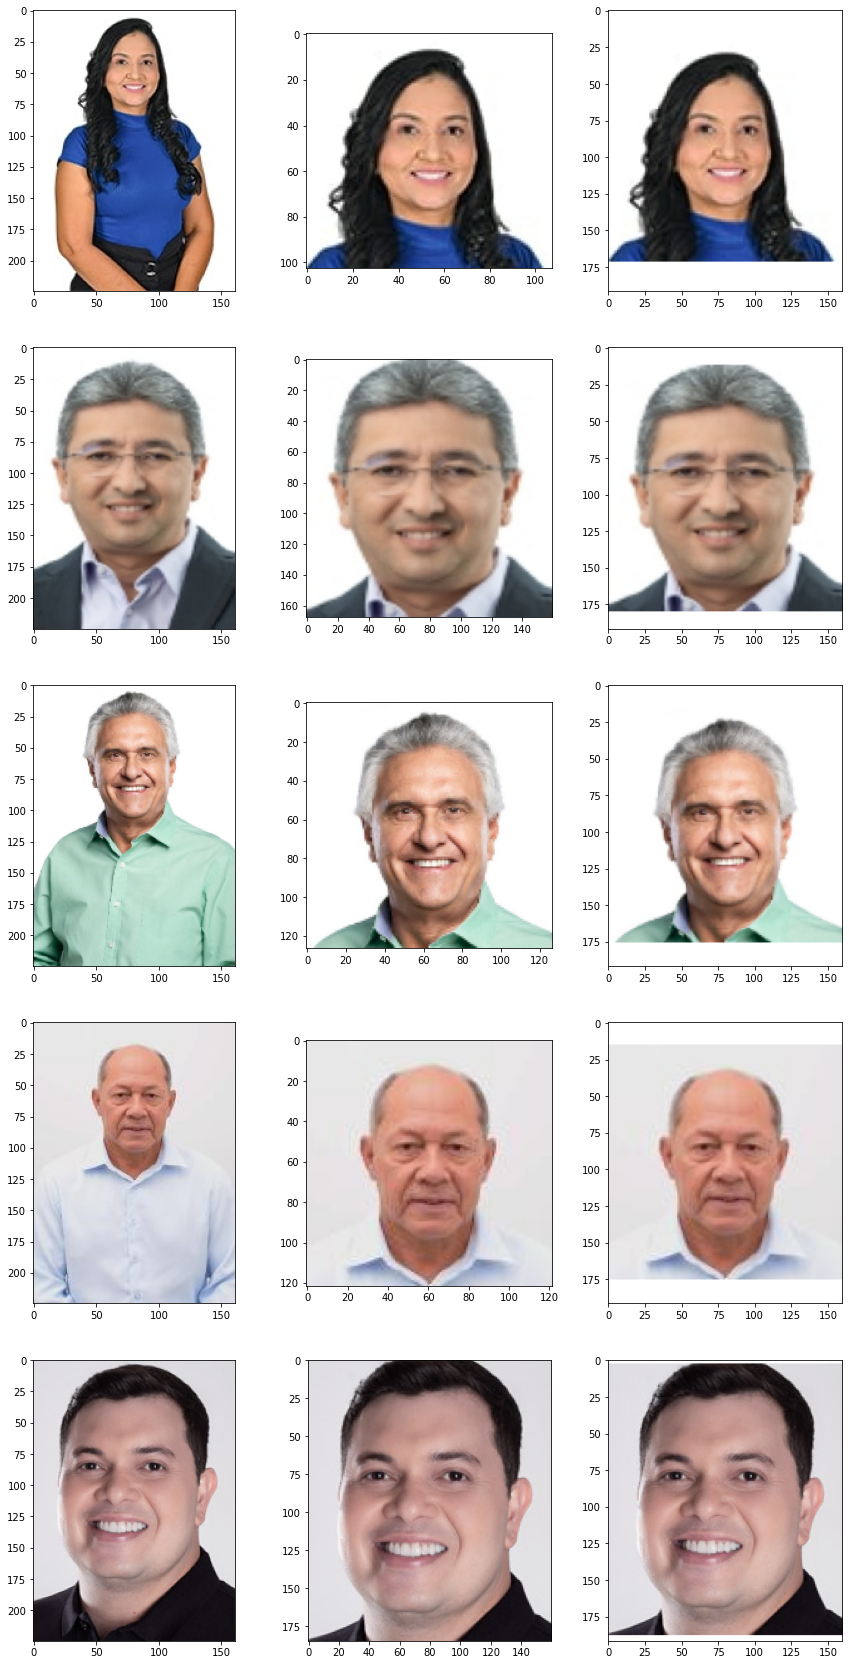

In [39]:
see_cropped_faces(elected_faces, cropped_elected_faces, resized_cropped_ellected_faces, 5)

PCA

Fonte: https://github.com/lewagon/data-challenges/blob/master/05-ML/06-Unsupervised-Learning/02-Face-Recognition/face_recognition.ipynb

In [47]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [48]:
PCA_COMPONENTS = 100
N_COMPONENTS_TO_PLOT = 1

Construir o PCA dos candidatos eleitos com 10 componentes

In [49]:
pca = PCA(n_components=PCA_COMPONENTS, svd_solver='full').fit(elected_flattened_faces/255)

Play

Imagem Original vs. Reconstrução de uma Imagem 

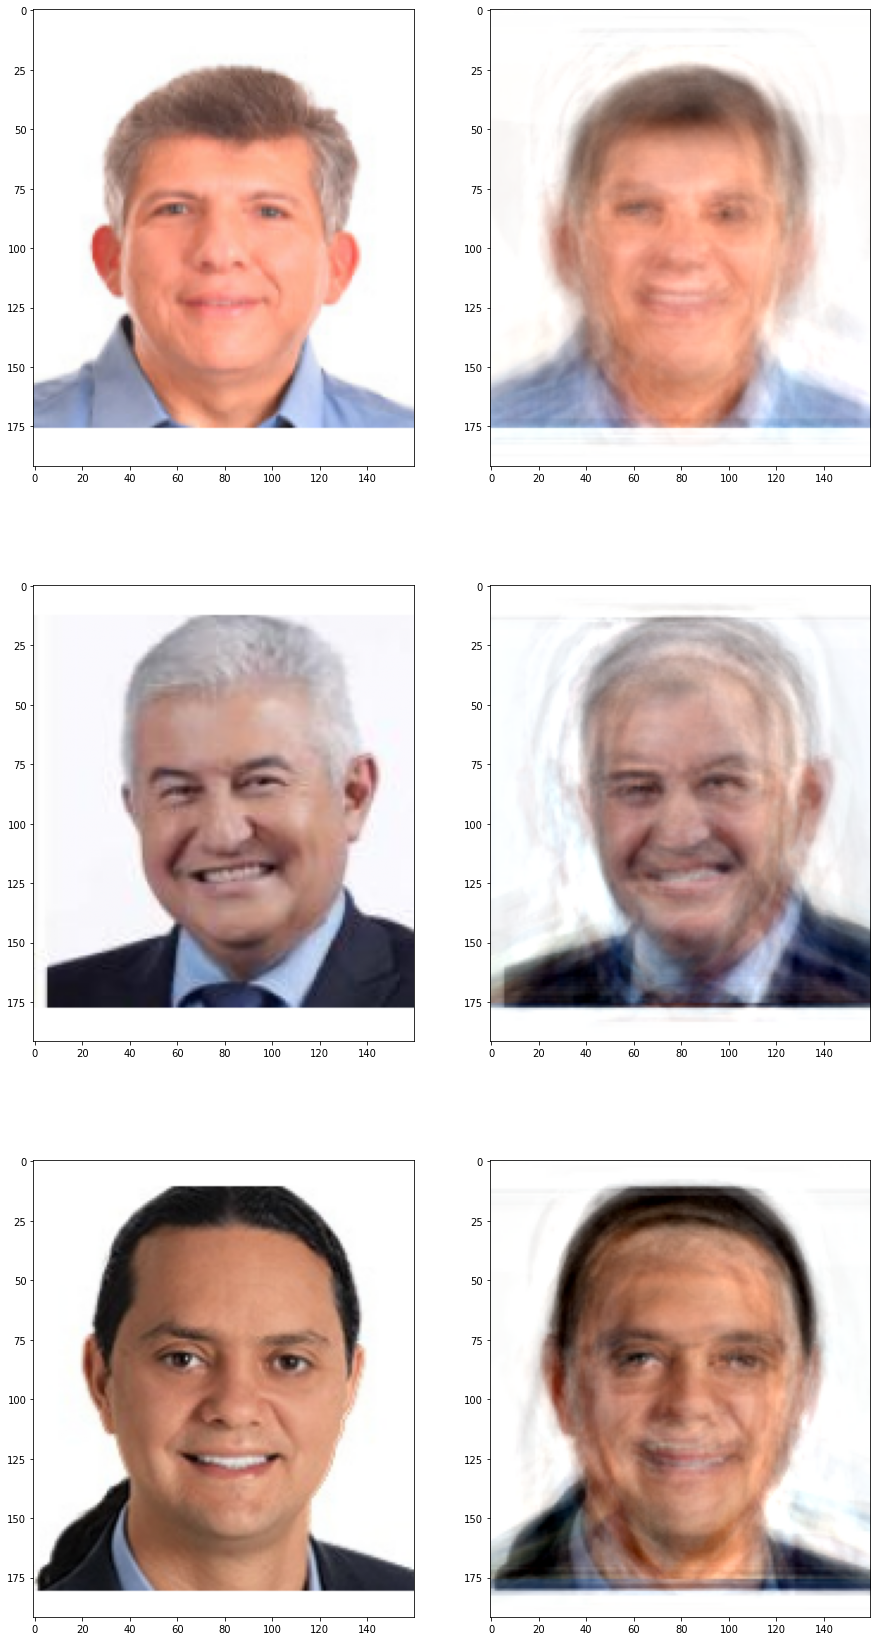

In [50]:
pca_plot_faces_and_their_reconstructions(pca, resized_cropped_ellected_faces/255, 3)

Imagens Reconstruídas

Reconstrução da imagem padrão de candidatos eleitos a partir do componente principal

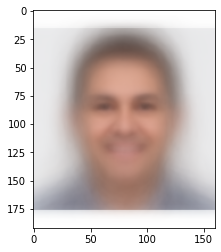

In [51]:
elected_mean_person_pca = pca.mean_.reshape(resized_cropped_ellected_faces.shape[1:])
plt.imshow(BGR2RGB(elected_mean_person_pca));

Busca pelo número ideal de componentes principais

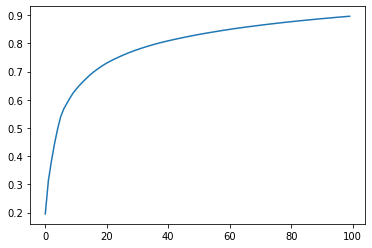

In [52]:
sns.lineplot(x=np.arange(pca.explained_variance_ratio_.shape[0]), y=pca.explained_variance_ratio_.cumsum())

Reconstrução da imagem padrão de candidatos eleitos a partir das componentes principais

In [53]:
def plot_main_components(pca, shape, n_components=1):
  sc = MinMaxScaler()
  sc = sc.fit(pca.components_)
  input_transformado = sc.transform(pca.components_[0:n_components])
  input_transformado = np.expand_dims(input_transformado.mean(axis=0), axis=1)
  input_transformado = input_transformado.reshape(shape)
  plt.imshow(BGR2RGB(input_transformado));

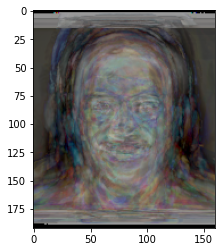

In [54]:
plot_main_components(pca, resized_cropped_ellected_faces.shape[1:], N_COMPONENTS_TO_PLOT)

Autoencoder

Fonte: https://github.com/heliomacedofilho/data-challenges/blob/master/06-Deep-Learning/03-Convolutional-Neural-Networks/05-Autoencoder/autoencoders.ipynb

In [6]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Reshape, Conv2DTranspose, Input, BatchNormalization, Dropout, Lambda, LeakyReLU, Masking
from tensorflow.keras import Model, backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.layers import Embedding
from sklearn.model_selection import train_test_split

In [7]:
latent_dimension = 500

In [22]:
def plot_history(history):
  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

  ax1.plot(history.history['loss'], label='train')
  ax1.set_title('loss')
  ax1.legend()

  ax2.plot(history.history['r_loss'], label='train r_loss')
  ax2.plot(history.history['kl_loss'], label='train kl_loss')

  ax2.set_title('Accuracy')
  ax2.legend()
  return (ax1, ax2)
  
def autoencoder_plot_faces_and_their_reconstructions(autoencoder, photos, n_photos):
  lines = np.random.choice(photos.shape[0], n_photos, replace=False)
  reconstructed_photos = autoencoder.predict(photos[lines])

  fig, axs = plt.subplots(n_photos, 2, figsize=(15,30))
  for idx, (img_orig, img_reconstructed) in enumerate(zip(photos[lines], reconstructed_photos)):
    axs[idx][0].imshow(BGR2RGB(img_orig));
    axs[idx][1].imshow(BGR2RGB(img_reconstructed));

def plot_randomly_created_faces(decoder, n_photos):
  randomly_created_faces = decoder.predict(np.random.normal(0,1,size=(n_photos,latent_dimension)))

  fig, axs = plt.subplots(1, n_photos, figsize=(15,30))
  for idx, randomly_created_face in enumerate(randomly_created_faces):
    axs[idx].imshow(BGR2RGB(randomly_created_face));


In [9]:
candidates_df = get_candidates()

elected_df = get_elected(candidates_df)[['filename']].copy()
elected_df['y'] = 1

not_elected_df = get_not_elected(candidates_df)[['filename']]
not_elected_indices = np.random.choice(not_elected_df.shape[0], elected_df.shape[0], replace=False)
not_elected_df = not_elected_df.iloc[not_elected_indices].copy()
not_elected_df['y'] = 0

#candidates_df = pd.concat([elected_df, not_elected_df], axis=0).sample(frac=1)
candidates_df = elected_df

In [10]:
X = get_resized_faces(get_cropped_faces(get_faces(candidates_df.drop(columns='y'))))
y = candidates_df['y']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [11]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train, y_train = X, y

Encoder

In [12]:
def build_prefix_encoder(input_shape, use_batch_norm = False, use_dropout = False):
    # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu, 
    # BatchNormalization and Dropout.
    # Otherwise, the names of above mentioned layers in the model 
    # would be inconsistent
    global K
    K.clear_session()

    '''returns an encoder model, of output_shape equals to latent_dimension'''
    encoder = Sequential()
    
    encoder.add(Masking(mask_value=255, input_shape=input_shape))

    encoder.add(Rescaling(1./255))

    encoder.add(Conv2D(32, (3,3), (2, 2), padding='same', activation='LeakyReLU'))
    if use_batch_norm: encoder.add(BatchNormalization())
    if use_dropout: encoder.add(Dropout(0.25))

    encoder.add(Conv2D(64, (3,3), (2, 2), padding='same', activation='LeakyReLU'))
    if use_batch_norm: encoder.add(BatchNormalization())
    if use_dropout: encoder.add(Dropout(0.25))

    encoder.add(Conv2D(64, (3,3), (2, 2), padding='same', activation='LeakyReLU'))
    if use_batch_norm: encoder.add(BatchNormalization())
    if use_dropout: encoder.add(Dropout(0.25))

    encoder.add(Conv2D(64, (3,3), (2, 2), padding='same', activation='LeakyReLU'))
    if use_batch_norm: encoder.add(BatchNormalization())
    if use_dropout: encoder.add(Dropout(0.25))

    shape_before_flattening = K.int_shape(encoder.layers[-1].output)[1:] 

    encoder.add(Flatten())

    return encoder, shape_before_flattening

def build_suffix_encoder(prefix_model, latent_dimension):
  prefix_model_input = prefix_model.layers[0].input
  prefix_model_output = prefix_model.layers[-1].output

  mean_mu = Dense(latent_dimension)(prefix_model_output)
  log_var = Dense(latent_dimension)(prefix_model_output)

  # Defining a function for sampling
  def sampling(args):
    global mean_mu
    global log_var
    mean_mu, log_var = args
    epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
    return mean_mu + K.exp(log_var/2)*epsilon

  concatenate = Lambda(sampling)([mean_mu, log_var])
  return Model(prefix_model_input, concatenate)

def build_encoder(input_shape, use_batch_norm = False, use_dropout = False, latent_dimension=200):
  prefix_encoder, shape_before_flattening = build_prefix_encoder(input_shape, use_batch_norm, use_dropout)
  encoder = build_suffix_encoder(prefix_encoder, latent_dimension)
  return encoder, shape_before_flattening

def build_decoder(input_shape, latent_dimension, shape_before_flattening):
  decoder = Sequential()
  decoder.add(Dense(np.prod(shape_before_flattening), input_shape=(latent_dimension, ), activation=None))
  decoder.add(Reshape(shape_before_flattening))
  decoder.add(Conv2DTranspose(64, kernel_size=(3,3), strides=(2,2), padding='same', activation='LeakyReLU'))
  decoder.add(Conv2DTranspose(64, kernel_size=(3,3), strides=(2,2), padding='same', activation='LeakyReLU'))
  decoder.add(Conv2DTranspose(32, kernel_size=(3,3), strides=(2,2), padding='same', activation='LeakyReLU'))
  decoder.add(Conv2DTranspose(3, kernel_size=(3,3), strides=(2,2), padding='same', activation='sigmoid'))
  return decoder

def build_autoencoder(input_shape, latent_dimension):
  encoder, shape_before_flattening = build_encoder(input_shape, True, True, latent_dimension)
  decoder = build_decoder(encoder.layers[-1].output, latent_dimension, shape_before_flattening)
  autoencoder = Model(encoder.layers[0].input, decoder(encoder.layers[-1].output))
  return autoencoder, encoder, decoder

In [13]:
encoder_model, shape_before_flattening = build_encoder(X_train.shape[1:], False, False, latent_dimension)
encoder_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 masking_input (InputLayer)     [(None, 192, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 masking (Masking)              (None, 192, 160, 3)  0           ['masking_input[0][0]']          
                                                                                                  
 rescaling (Rescaling)          (None, 192, 160, 3)  0           ['masking[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 96, 80, 32)   896         ['rescaling[0][0]']          

Decoder

In [14]:
decoder_model = build_decoder(X_train.shape[1:], latent_dimension, shape_before_flattening)
decoder_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 7680)              3847680   
                                                                 
 reshape (Reshape)           (None, 12, 10, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 24, 20, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 48, 40, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 96, 80, 32)       18464     
 ranspose)                                                       
                                                      

Autoencoder

In [15]:
autoencoder, encoder, decoder = build_autoencoder(X_train.shape[1:], latent_dimension)
autoencoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 masking_input (InputLayer)     [(None, 192, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 masking (Masking)              (None, 192, 160, 3)  0           ['masking_input[0][0]']          
                                                                                                  
 rescaling (Rescaling)          (None, 192, 160, 3)  0           ['masking[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 96, 80, 32)   896         ['rescaling[0][0]']        

Treino

In [18]:
LEARNING_RATE = 0.0005
N_EPOCHS = 300
LOSS_FACTOR = 10000
BATCH_SIZE = 32

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])
  
def kl_loss(y_true, y_pred):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean_mu) - K.exp(log_var), axis = 1)
    return kl_loss

def total_loss(y_true, y_pred):
    return LOSS_FACTOR*r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)
  
adam_optimizer = Adam(learning_rate = LEARNING_RATE)

autoencoder.compile(optimizer=adam_optimizer, loss = total_loss, metrics = [r_loss, kl_loss])

#checkpoint_vae = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER, 'VAE/weights.h5'), save_weights_only = True, verbose=1)
es = EarlyStopping(patience=5, restore_best_weights=True)

history = autoencoder.fit(X_train, X_train/255,
                shuffle=True,
                epochs = N_EPOCHS,
                initial_epoch = 0,
                steps_per_epoch=X_train.shape[0] / BATCH_SIZE,
                callbacks=es)
                #callbacks=[checkpoint_vae])

plot_history(history)

Epoch 1/5
17/16 [==============================] - ETA: 0s - loss: 2137.3757 - r_loss: 0.1340 - kl_loss: 797.2476

16/16 [==============================] - 32s 1s/step - loss: 2137.3757 - r_loss: 0.1340 - kl_loss: 797.2476
Epoch 2/5
17/16 [==============================] - ETA: 0s - loss: 1510.9854 - r_loss: 0.0996 - kl_loss: 515.1240

16/16 [==============================] - 24s 1s/step - loss: 1510.9854 - r_loss: 0.0996 - kl_loss: 515.1240
Epoch 3/5
17/16 [==============================] - ETA: 0s - loss: 1089.2751 - r_loss: 0.0570 - kl_loss: 519.6657

16/16 [==============================] - 24s 1s/step - loss: 1089.2751 - r_loss: 0.0570 - kl_loss: 519.6657
Epoch 4/5
17/16 [==============================] - ETA: 0s - loss: 955.3771 - r_loss: 0.0469 - kl_loss: 485.8893

16/16 [==============================] - 26s 2s/step - loss: 955.3771 - r_loss: 0.0469 - kl_loss: 485.8893
Epoch 5/5
17/16 [==============================] - ETA: 0s - loss: 817.4294 - r_loss: 0.0408 - kl_loss: 409.6658

16/16 [==============================] - 31s 2s/step - loss: 817.4294 - r_loss: 0.0408 - kl_loss: 409.6658


Play

Reconstituir fotos de candidatos eleitos

1/1 [==============================] - 0s 406ms/step


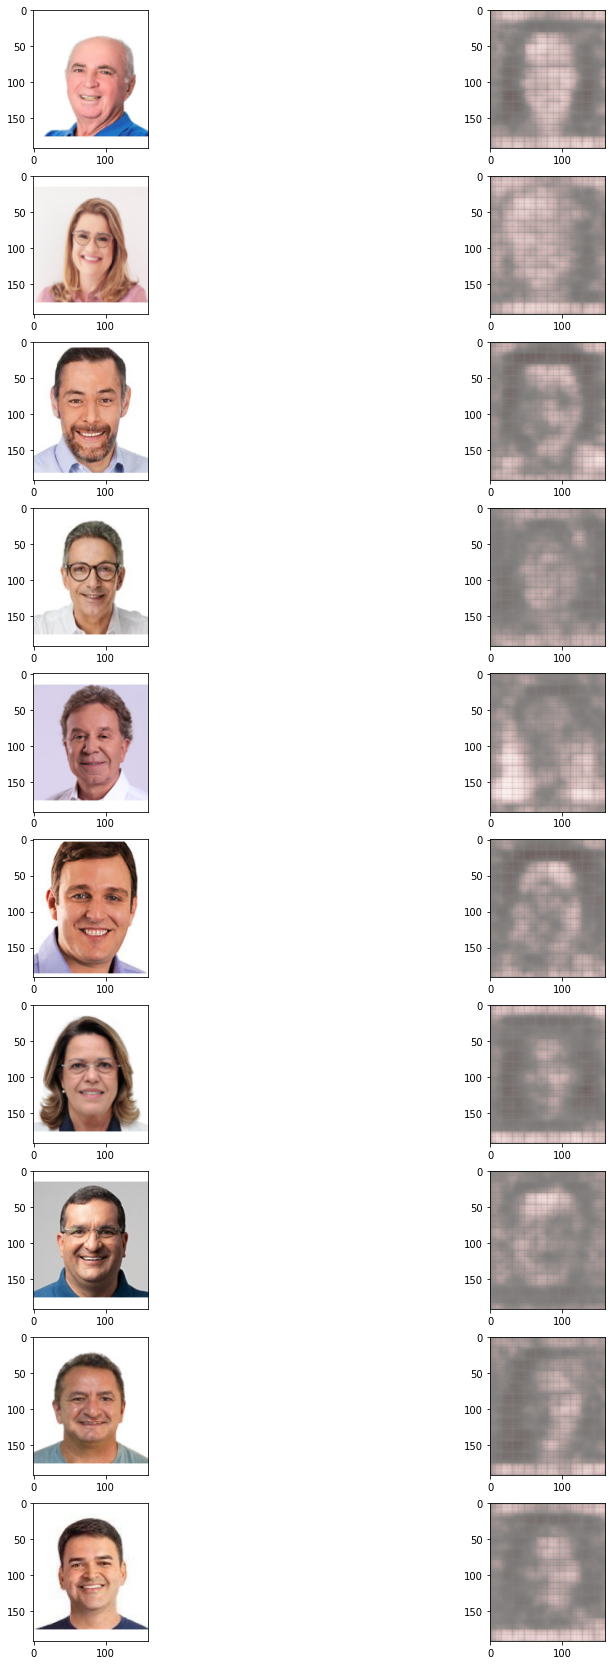

In [23]:
autoencoder_plot_faces_and_their_reconstructions(autoencoder, X_train, 10)

Criar aleatoriamente rosto de candidato eleito

1/1 [==============================] - 0s 150ms/step


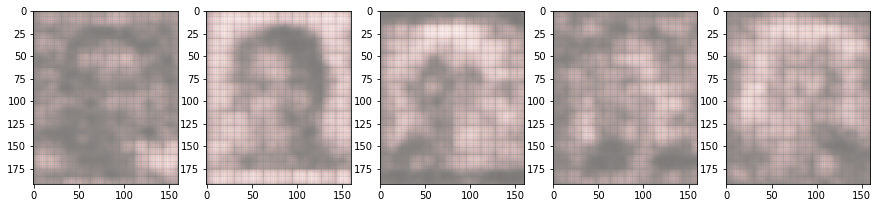

In [24]:
plot_randomly_created_faces(decoder, 5)

Reconstrução de faces a partir de candidatos não presentes no treino

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


1/1 [==============================] - 0s 406ms/step


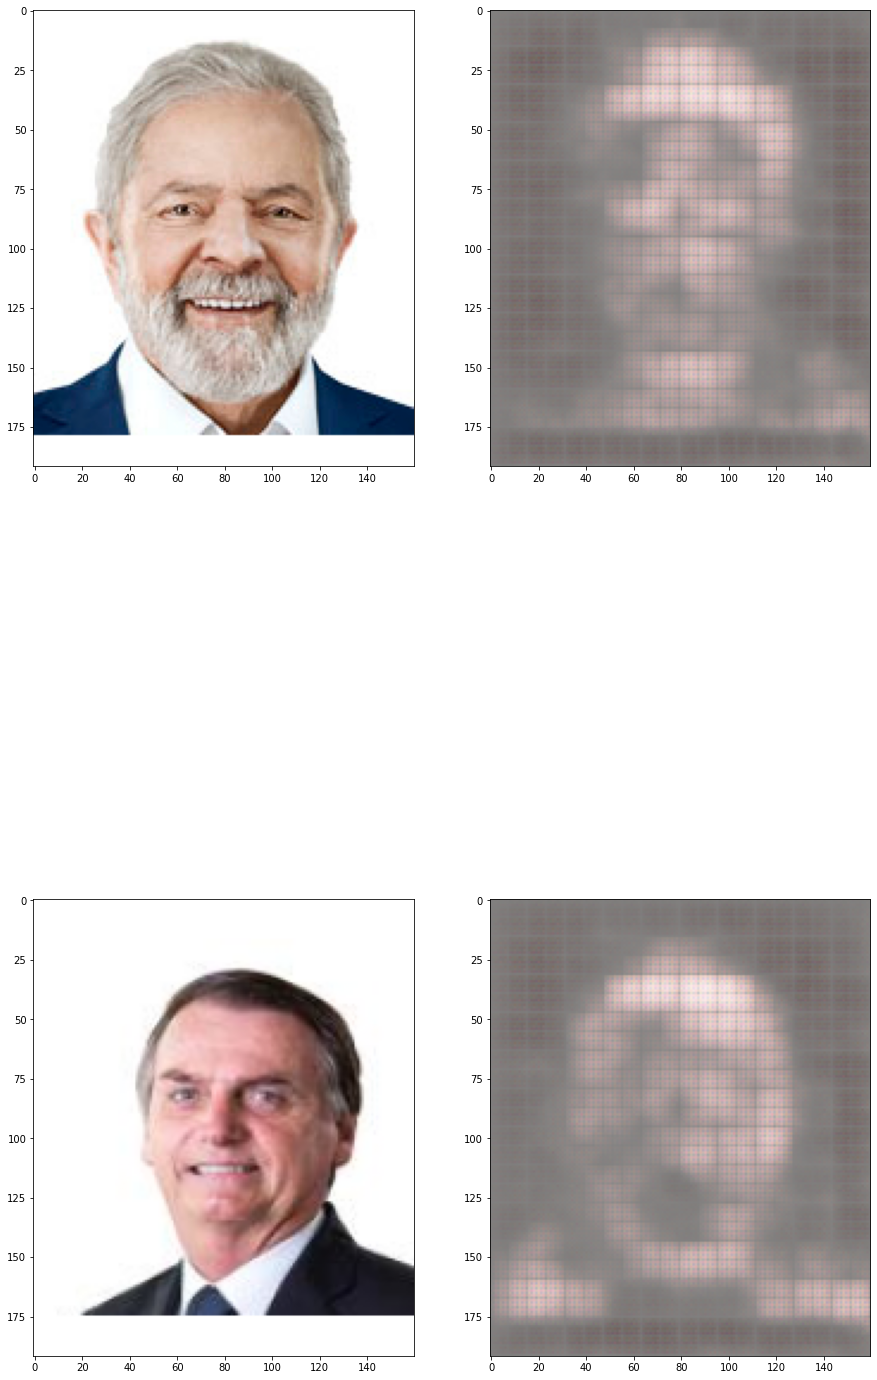

In [25]:
url_foto_lula = 'https://divulgacandcontas.tse.jus.br/candidaturas/oficial/2022/BR/BR/544/candidatos/893498/foto.jpg'
url_foto_bolsonaro = 'https://divulgacandcontas.tse.jus.br/candidaturas/oficial/2022/BR/BR/544/candidatos/908966/foto.jpeg'
foto_lula = open_image_internet(url_foto_lula)
foto_bolsonaro = open_image_internet(url_foto_bolsonaro)
presidenciaveis = get_resized_faces(get_cropped_faces([foto_lula, foto_bolsonaro]))/255
autoencoder_plot_faces_and_their_reconstructions(autoencoder, presidenciaveis, presidenciaveis.shape[0])

Reconstrução de faces a partir de candidatos eleitos

17/17 [==============================] - 0s 18ms/step


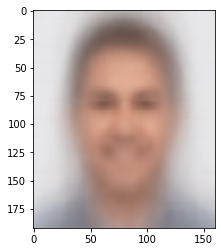

In [ ]:
elected_mean_person_autoencoder = autoencoder.predict(X)
elected_mean_person_autoencoder = elected_mean_person_autoencoder.reshape((elected_mean_person_autoencoder.shape[0], np.prod(elected_mean_person_autoencoder.shape[1:]))).mean(axis=0).reshape(elected_mean_person_autoencoder.shape[1:])
plt.imshow(BGR2RGB(elected_mean_person_autoencoder))